Sai Saradha Kalidaikurichi Lakshmanan
EECS 531 - Assignment A1

Exercise 3:
Make a notebook for feature detector, e.g. the letter ‘h’ as shown in the lecture.

Letter detection is commonly used in character recognition based applications. There are a wide range of approaches for solving the letter detection problem, ranging from template matching, feature based methods to Machine learning based algorithms. In this exercise we explore the template matching methods with different measures such as SSD, SAD, NCC, etc., The importance of image smoothing is also studied. We observe and explain the limitations in this model and go on to experiment with more advanced and sophisticated technique - Deep Learning. In this exercise, I have implemented my own Strawberry detector using the Object Detection API in Tensorflow and try to detect strawberries in an image. Implementation details and analysis of the results is also presented.

In [1]:
import numpy as np
import os
import cv2
from scipy import ndimage
import scipy
import time
import math
from matplotlib import pyplot as plt
import scipy.io as spio

In [2]:
class feature_detectors:
    
    def __init__(self):
        pass

    def get_image_shape(self, img):
        return img.shape[0], img.shape[1]

    def conv_im(self, Img, kernl):
        return (ndimage.convolve(Img, kernl, mode='constant', cval=0.0)).astype(np.float64)

    def norm_hist(self, img):
        plt.hist(img.ravel(),256,[0,256]);
        plt.show()
        return

    def calc_hist(self, img):
        hist_img = cv2.calcHist([img],[0],None,[256],[0,256])
        return hist_img

    def color_hist(self, img):
        color = ('b','g','r')
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.show()
        return

    def canny_edge(self, img):
        t = self.otsu_thresh(img)
        edge_img = cv2.Canny(img,t/2,t)
        cv2.imshow('Canny', edge_img.astype(np.uint8))
        cv2.waitKey(0)
        return
    
    def _pad(self, Img, fs):
        # pad with zeros on all sides depending on the filter size
        ps = int(fs/2)
        pimg = np.pad(Img, (ps,), 'constant', constant_values = 0)
        return pimg
    
    def kernel_img_conv(self, Img, fs, kernelb):
        # get padded image:
        pimg = self._pad(Img, fs)
        # get the image shape
        height = Img.shape[0]
        wd = Img.shape[1]
        # create an array for the blurred image
        Img_final = np.zeros((height, wd))
        for h in range(height):
            for w in range(wd):
                Img_final[h,w] =(np.sum(np.multiply(kernelb, pimg[h:h+fs,w:w+fs])))
        return Img_final

    def image_pyramid_search(self):
        pass

    def get_template_avg(self, tmpf):
        h, w = 0, 0
        img_count = 0
        directory = os.fsencode(tmpf)
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            mat = spio.loadmat(tmpf+filename)
            img = mat['T']
            #img = cv2.imread(tmpf+filename,0)
            if img is None:
                print('Invalid image:' + filename)
                continue
            if img_count == 0:
                h, w = self.get_image_shape(img)
                img_sum = np.zeros((h,w))
                return img # comment this when using average image
            else:
                img_sum += img
                img_count+= 1
        avg_templ = img_sum/img_count
        return avg_templ

    def extents(self, f):
        delta = f[1] - f[0]
        return [f[0] - delta/2, f[-1] + delta/2]

    def ssd_val(self, patch, tmpl_img):
        return sum((np.ravel(patch)-np.ravel(tmpl_img))**2)

    def sad_val(self, patch, tmpl_img):
        return sum(abs(np.ravel(patch)-np.ravel(tmpl_img)))

    def ncc_val(self, patch, tmpl_img):
        return np.correlate(np.ravel(patch), np.ravel(tmpl_img))

    def select_choice(self, metric, patch, tmpl_img):
        choices = {'ssd':self.ssd_val,
                   'sad':self.sad_val,
                   'ncc':self.ncc_val,
            }
        return choices[metric](patch, tmpl_img)

    def correlate_img(self, fd_choice, imfolder, tmpl_img):
        directory = os.fsencode(imfolder)
        for file in os.listdir(directory):
            tic = time.time()
            filename = os.fsdecode(file)
            print(filename)
            Img = self.read_image(imfolder, filename)
            RI = Img
            cv2.imshow('image uint', Img.astype(np.uint8))
            cv2.waitKey(0)
            Img = cv2.normalize(Img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            cv2.imshow('norm im', Img)
            cv2.waitKey(0)
            if Img is None:
                continue
            o_h, o_w = self.get_image_shape(Img)
            t_h, t_w = self.get_image_shape(tmpl_img)
            rh = o_h - t_h + 1
            rw = o_w - t_w + 1
            D = np.zeros((rh,rw), dtype=float)
            for r in range(rh) :
                for c in range(rw):
                    patch = Img[r:r+t_h, c:c+t_w]
                    D[r, c] = self.select_choice(fd_choice, patch, tmpl_img)
                    #D[r,c] = sum((np.ravel(patch)-np.ravel(tmpl_img))**2)
                    # D[r,c] = np.correlate(np.ravel(patch), np.ravel(tmpl_img))
            # D = D.astype(np.uint8)
            plt.figure()
            plt.imshow(D, aspect='auto', interpolation='nearest',origin='lower')
            # threshold and plot the results
            thresh = 10
            '''for r in range(rh):
                 for c in range(rw):
                    if D[r,c] < thresh:
                        cv2.rectangle(RI,(r, c),(r+t_h, c+t_w), (0,255,0),2)'''
            '''RI = Img
            ind_max_corr_y, ind_max_corr_x = np.where(D == np.max(D))
            for i in ind_max_corr_y:
                for j in ind_max_corr_x:
                    yoffset = i - t_h
                    xoffset = j - t_w           
                    cv2.rectangle(RI, (yoffset, yoffset+t_h), (xoffset, xoffset+t_w), (0, 255,0),2)'''
            a,b = np.where(D < thresh)
            # a,b = np.where (D > thresh)
            ll = len(a)
            for i in range(ll):
                    cv2.rectangle(RI,(b[i],a[i]),(b[i]+t_w,a[i]+t_h),(0,255,0),2)
            cv2.imshow('Detected Image', RI.astype(np.uint8))
            cv2.waitKey(0)
            cv2.imwrite('E3_images\\'+str(filename),RI.astype(np.uint8))
        return
            
    def template_matching(self, fd_choice, img_folder, tmpf):
        # lets create the average template image (just simply using np.mean) or take the template directly
        templ_img = self.get_template_avg(tmpf)
        if templ_img is None:
            print('average template image is invalid')
            return
        cv2.imshow('Template', templ_img.astype(np.uint8))
        cv2.waitKey(0)
        # now time to convolve this average template image over the test images:
        self.correlate_img(fd_choice, img_folder, templ_img)
        # smooth image
        # change color channel
        return

    # for testing purposes (from opencv)
    def builtin_templ(self):
        img = cv2.imread('..\\Test_straw\\S1.jpg',0)
        img2 = img.copy()
        template = cv2.imread('..\\Test_straw\\0_100.jpg',0)
        w, h = template.shape[::-1]
        # All the 6 methods for comparison in a list
        methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
        for meth in methods:
            img = img2.copy()
            method = eval(meth)
        # Apply template Matching
        res = cv2.matchTemplate(img,template,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(img,top_left, bottom_right, 255, 2)
        plt.subplot(121),plt.imshow(res,cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(img,cmap = 'gray')
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        plt.suptitle(meth)
        plt.show()
        return

    def gaussian(self, Img, fs):
        gridx, gridy = scipy.mgrid[-(int(fs/2)):int(fs/2)+1, -(int(fs/2)):int(fs/2)+1]
        sigma = 1
        # nc = 1/(2*np.pi*(sigma**2))
        gkernel = np.exp(-(gridx**2 + gridy**2)/(2*(sigma**2))).astype(np.float32)
        nc = 1/(gkernel.sum()).astype(np.float32)
        gkernel = nc*gkernel
        Img_final = self.kernel_img_conv(Img, fs, gkernel)
        Img2 = Img_final.astype(np.uint8)
        cv2.namedWindow('Gaussian Blur')
        cv2.imshow('Gaussian Blur',Img2)
        cv2.waitKey(0)

        # interesting experiment:
        # Inspired from CMU lecture, we can introduce shadow effect in images by
        # overlaying the original image and the gaussian blurred image
        self.shadow_effect_analysis(Img, Img2)
        return Img2
    
    def read_image(self, directory, filename):
        # if filename.startswith("t") and (filename.endswith(".jpg") or filename.endswith(".bmp") or filename.endswith(".png") or filename.endswith(".gif") or filename.endswith(".tif")):
        if filename.endswith(".jpg") or filename.endswith(".bmp") or filename.endswith(".png") or filename.endswith(".gif") or filename.endswith(".tif"):
            print(filename)
            img = cv2.imread(directory + filename,0)
            if img is None:
                print('Invalid image:' + filename)
                return None
            else:
                cv2.imshow('Original Image', cv2.imread(directory + filename,-1))
                cv2.waitKey(0)
                return img
            
    def main(self, img_folder, tmpf, fd_choice):
        options = {'ssd':self.template_matching,
                   'sad':self.template_matching,
                   'ncc':self.template_matching,
            }
        options[fd_choice](fd_choice, img_folder, tmpf)
        return

In [ ]:
if __name__ == "__main__":

    # creating an instance of the feature detector class
    fd_class = feature_detectors()

    # Call to the main function
    # Arguments to the main function are directory to test images
    # filter choice and filter size
    tic = time.time()
    fd_class.main("..\\Test_h\\", input("Enter path to template: "), input("Enter the preferred feature detector: "))
    toc = time.time() - tic
    print("Total Running time: " + str(toc))
# path to template - ..\\template\\


Brief description of the template matching methods :
Template matching techniques work by trying to find the smaller template in the larger image. This is done by taking the template and running it through the image to find regions that have the most similarity or least difference. Accordingly, three of the popular metrics are - Sum of Squared Differences (SSD), Sum of Absolute Differences (SAD) and Normalized Cross Correlation (NCC)
The SSD metric find the squared difference as the name suggests and is hence computationally more expensive than its SAD counterpart where the absolute differences between the patch and the template are directly summed up, hence the latter is more efficient. However, the other NCC algorithm matches two images, the reference and the template by performing a discrete cross correlation be-tween the two images at every possible location in the ref-erence image. NCC is a simpler method but is considerably effective compared to other methods such as SAD and SSD. The range of the correlation value is between -1 and +1 and this is because the correlation computation is equivalent to finding the dot product between two unit vectors,. Since it is normalized, NCC is less sensitive to the luminance variation.

The computation for the three metrics are as follows (here f and g are the image patch and template respectively) :

$$\mathrm{SSD}(f,g) : \sum_{[i,j]\in R} \left(f(i,j)-g(i,j)\right)^{2}$$
$$\mathrm{SAD}(f,g) : \sum_{[i,j]\in R} \left|f(i,j)-g(i,j)\right|$$
$$\mathrm{NCC}(f,g) : \sum_{[i,j] \in R}\hat{f}(i,j)\hat{g}(i,j) = \sum_{[i,j] \in R} \Bigg(\frac{f-\bar{f}}{\sqrt{\sum(f-\bar{f})^{2}}}\Bigg)\Bigg(\frac{g-\bar{g}}{\sqrt{\sum(g-\bar{g})^{2}}}\Bigg)$$


The procedure followed for template matching is :
1. Get the template (can use the direct template image, matrix file or compute the average image as template)
2. Normalize image (intensity values ranging from 0 to 1)
3. Compute SSD, SAD or NCC matrix
4. Set a threshold value
5. Find regions in the image where the value is less than the threshold
6. Those are the detected regions, draw bounding boxes around them

Here are the results of the template matching :
1. Thresholded by SSD
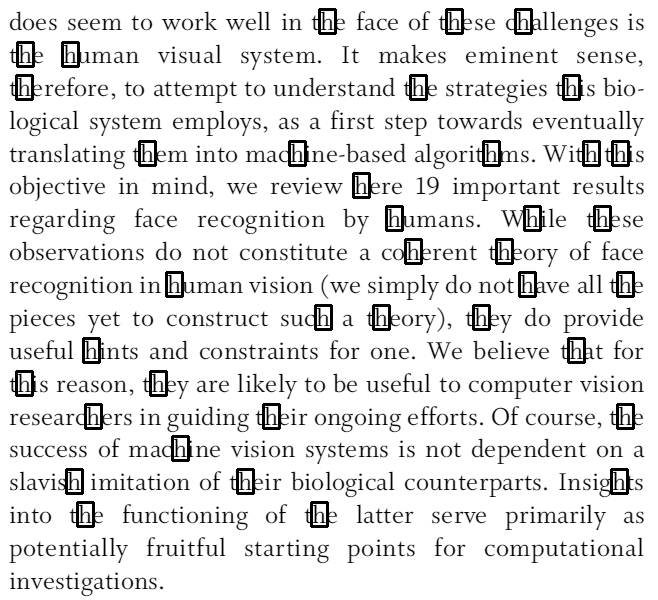
2. Low threshold with SAD (less number of 'h's detected)
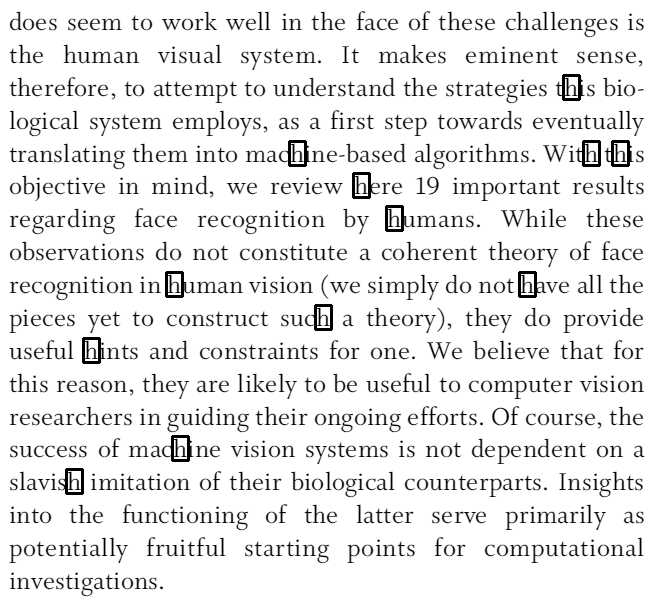
4. Correct threshold value SAD
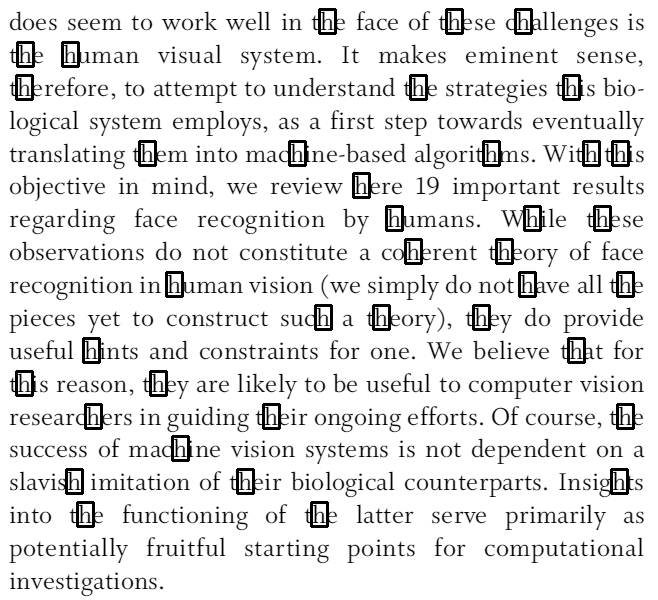

As we can observe from these techniques, they are very susceptible to the illumination and rotation variance. Infact even the size and structure of the template plays a very important role in matching the images rightly. I tried to detect strawberries in an image with this implementation with a template image and found that unless they are very similar in size, shape and structure, the template could not correctly identify. Hence, more sophisticated methods such as SIFT, SURF come into play.

So the topic feature detection itself is very dense. Most of the times, you detect features using feature detection techniques discussed above and then extract those features and use them for further processing (ML, Image Processing, etc). These extracted features can be used to train ML algorithms to recognize the object.This inspired me to implement an object detector of my own.  Hence I did the following.

# STRAWBERRY DETECTION USING TENSORFLOW (Object detection API and explored the GCP (Google Cloud Platform) by training, validating and testing the model on gcloud ML Engine

I used tensorflow to train strawberry detector. I did the following:

1. Collect strawberry images :
I collected images in two ways - 
a. https://github.com/Horea94/Fruit-Images-Dataset - had images of strawberry in varying pose and angles (i took approximately 300) of these images
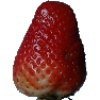
b. Handpicked images from Google Image search and downloaded them
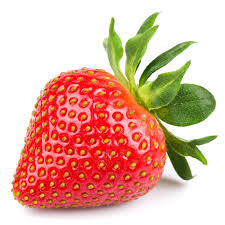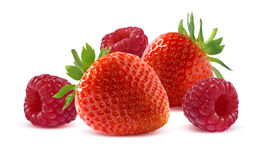

2. Hand label images - 
Tensorflow required the data to be in TRF format. To produce this we need, the object name, id, bounding boxes for the object (used during training and evaluation)

I used the tool LabelImg to label the images with strawberry and this tool automatically produces the xml files. Sample xmls files are also attached below:
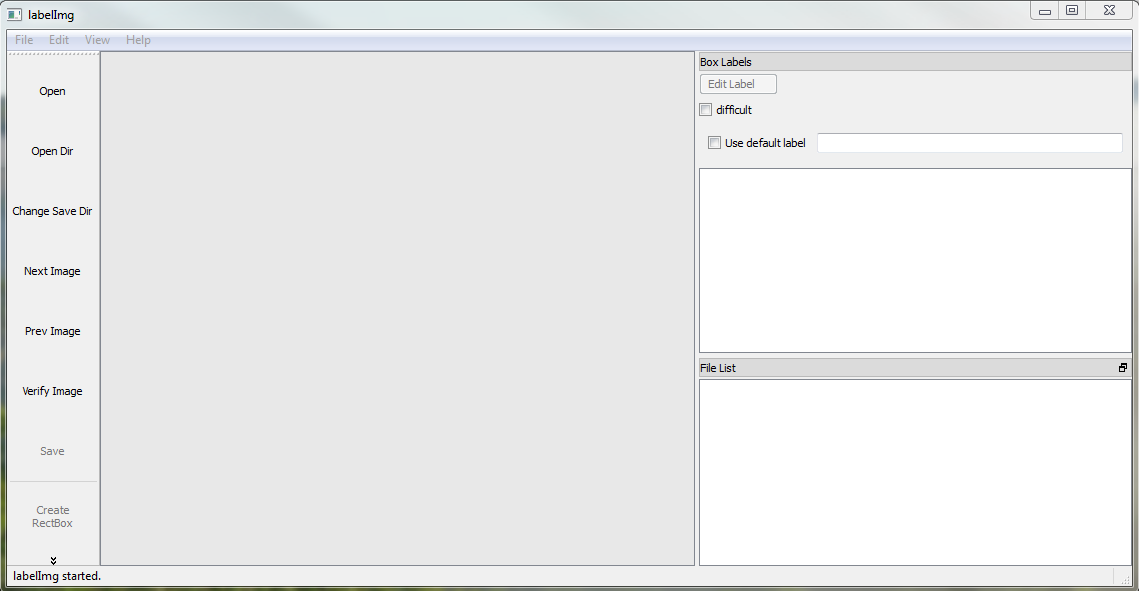

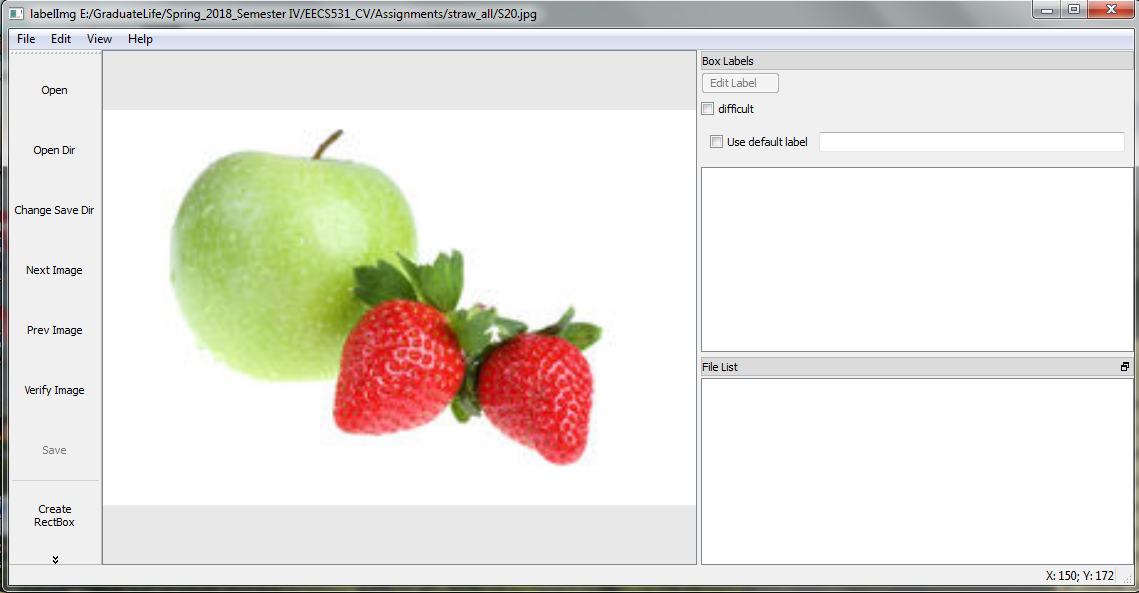

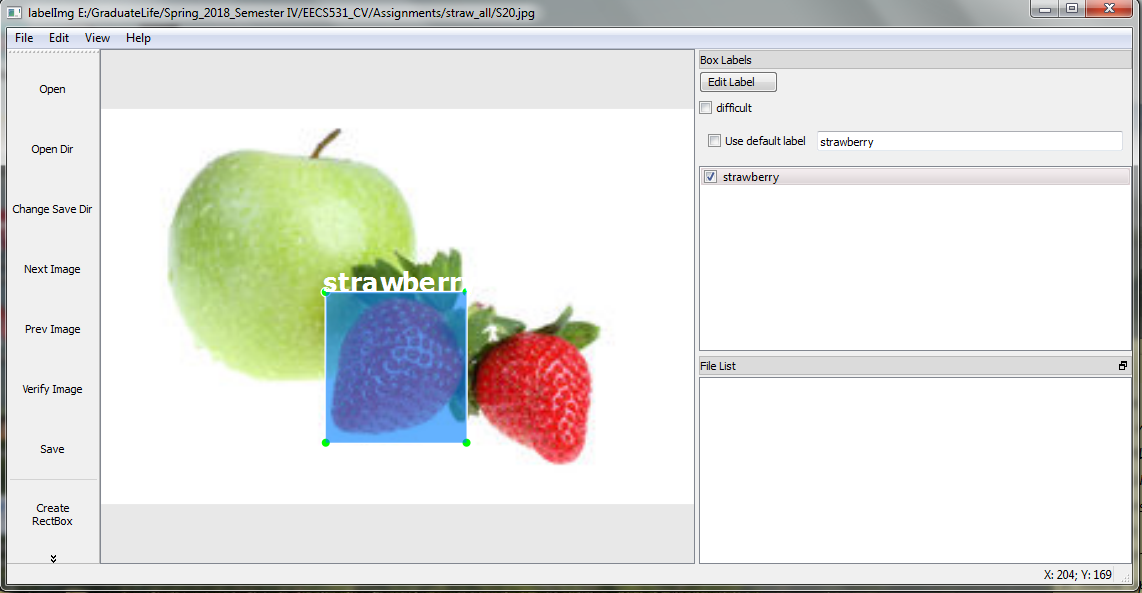

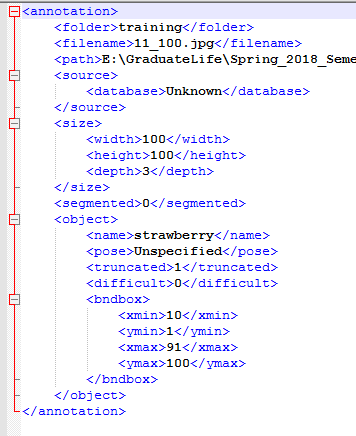

Once the xml is generated, I ran a python script to create the TFRecord files (both for training data and test data).

I used the SSD Mobilenet model available in tensorflow. Link to the model - https://www.cs.unc.edu/~wliu/papers/ssd.pdf 
The mobilenet version is faster as it was created for the mobile phones, hence I chose this one. Discussion about the model, parameters and the configurations might become too long, hence cutting down all that information here. Another reason for choosing this model is because this model available in the object detection API has already been trained on the Coco dataset (more info about coco here - http://cocodataset.org/#home) and this dataset has not been trained on strawberries and hence I thought it would be a good idea to start training the model with the trained ssd mobilenet model and this did seem to work well.

The next step is to create an object detection pipeline and I followed the steps available here - https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/configuring_jobs.md

It is important to create a label map for the dataset that has the labels and I created it like this :
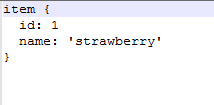

Now with all the files I started training the model on google cloud. The reason for going with the cloud compute engine is because I dont have GPU in my laptop and it would be impossible to run the training locally. There is a procedure to set up the cloud account, create project and buckets for storing data. I did all of this and then trained the model.

The loss dropped to 1.0 pretty soon in about thousand iterations but it took a while for the loss to be stable (~0.5). 

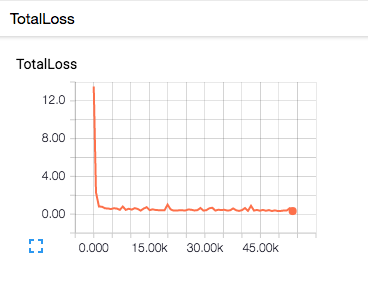

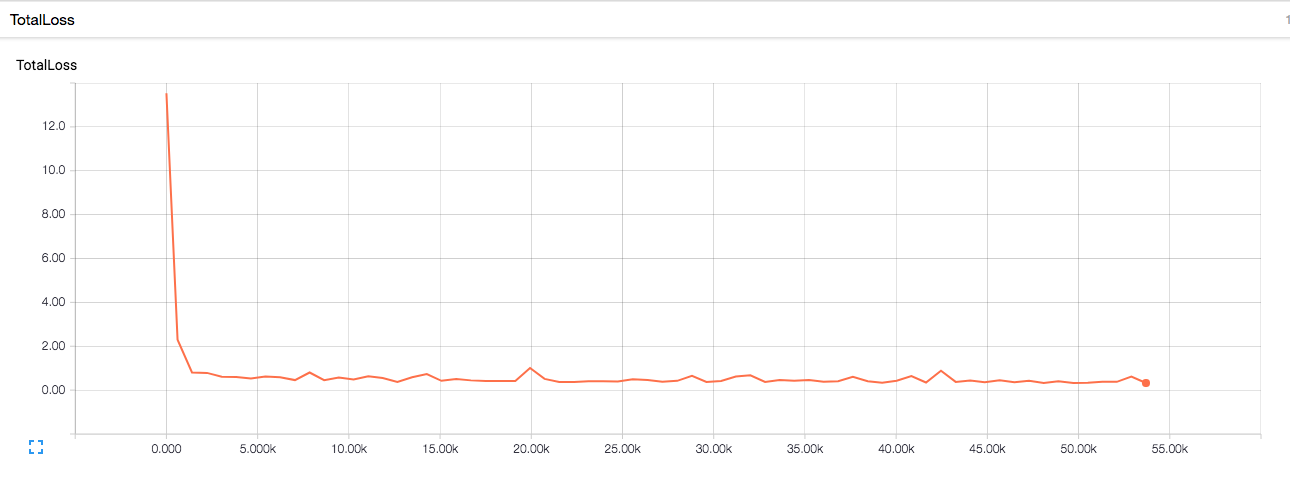

I tried running evaluation on google cloud but the current version of tensorflow on cloud does not have a module (pycocotools) and the team is still working to get it added in the next release. I am still trying to find other ways to run the evaluation.

I also did batch prediction on the test images, but unable to attach the images due to a bug in the run, I will share the detection results separately once that gets fixed.

It was a good learning experience to try and build my own strawberry detector from scratch. Given the timeframe of the assignment I could not spend a lot of time in finetuning the model parameters and configurations. Some of the parameters I used default values while for others I tried to use the one that looked good from my knowledge. I would like to improve this model further and I will continue doing this after the assignment submission as well.

More work - I was also interested in trying few library-available feature based methods (SIFT, SURF) and other ML methods (MAP based) to show how these are more robust to luminance and rotation variances compared to the template matching techniques.
Exploring Non-maxima supression as a way of reducing false positives could have been done too.
These template matching methods are known to be slow, so image pyramid implementation would have really enhanced the speed of the matching. An interesting fact on mean subtraction is also tried.